## Question 1

In [1]:
# Import necessary packages
import csv                               # csv reader
from sklearn.svm import LinearSVC
!pip install nltk
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [2]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path, encoding='utf-8') as f: #add 'encoding = utf-8' to original load_data function to avoid loading error
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

In [3]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    
    # the function input (data_line) should be a list, then subset the list with index 1 to get the 'label' data
    label = convert_label(data_line[1]) # implement convert_label function to make it into 2 classes 'fake' and 'real'
    # the same approach can be applied to extract 'text' data with index 2
    text = data_line[2]
    return (label, text) # return the tuple (label, text), which has the same order as in the 'load_data' function

In [4]:
# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    tokens_list = text.split() # string split method used for tokenizing, using default separator (any whitespace)
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    return tokens_list # Return the token_list for further use

## Question 2

In [5]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    feature_dict = {} # Created an empty dictionary (local feature dictionary) to store the vocab
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    for i in tokens: # Loop the input tokens. 
        #For each token, look up in the global dictionary to see if it exists
        if i not in global_feature_dict: # If no, then assign value 1 for that token and add it to the global dictionary
            global_feature_dict[i] = 1
        else: # If yes, then take the values (weights) to add 1 more (values + 1) and update it into the global dictionary
            global_feature_dict[i] = float(global_feature_dict[i] + 1)
        #For each token, look up in the feature dictionary to see if it exists (same approach as above)
        if i not in feature_dict:  # If no, then assign value 1 for that token and add it to the feature dictionary
            feature_dict[i] = 1
        else: # If yes, then take the values (weights) to add 1 more (values + 1) and update it into the feature dictionary
            feature_dict[i] = float(feature_dict[i] + 1)
    return feature_dict # Return the feature dictionary

In [6]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

## Question 3

In [211]:
# Check fake-real news ratio
raw_data = []
load_data('fake_news.tsv')
count_fake = 0
for i in raw_data:
    if i[1] == 'FAKE':
        count_fake += 1
print ('Number of fake news and its percentage: ', count_fake, ' & ', count_fake/len(raw_data))
print ('Number of real news and its percentage: ', len(raw_data) - count_fake, ' & ', 1 - count_fake/len(raw_data))

Number of fake news and its percentage:  4488  &  0.43828125
Number of real news and its percentage:  5752  &  0.56171875


The ratio shows that the distribution of labels seems to inclined a bit more to REAL news; therefore, we need to take this into account (probably) when calculating model performance

In [7]:
#solution
from sklearn.metrics import classification_report, accuracy_score
from random import shuffle # Import shuffle method

def cross_validate(dataset, folds):
    shuffle(dataset) # Shuffle the input dataset
    results = [] # Create an empty list to store the result after running the function
    fold_size = int(len(dataset)/folds) + 1 # Set number of folds to run
    accuracy_rate = [] # Create list to store accuracy
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        # Set up validation dataset in cross-validation with its size being equal to 1 fold_size
        validation = dataset[i : i+fold_size]
        # Set up trainset in cross-validation by excluding the validation set from the input dataset, and then take the rest
        train = dataset[:i] + dataset[i+fold_size:]
        # Train the classifier with the pipeline function created with the model initialiser (LinearSVC in this case)
        classifier = train_classifier(train)
        # Extract the ground-truth labels from the validation dataset
        yval_true = [t[1] for t in validation]
        # Implement the trained model into validation set and get predicted labels
        yval_pred = predict_labels([x[0] for x in validation], classifier)
        # Calculate precision, recall and fscore from the prediction, compared to ground truth 
            # use average = weight, due to skewness in FAKE-REAL news distribution
        final_scores = precision_recall_fscore_support(yval_true, yval_pred, average='weighted', zero_division=0) # evaluate
        # Calculate model accuracy
        accuracy = accuracy_calculate(yval_true, yval_pred)
        # Append the value to the list created at the top for storage
        results.append(final_scores)
        accuracy_rate.append(accuracy)
    # Convert list 'results' to array for easy further calculation
    cv_results = np.asarray(results)
    # Calculate the average precision score after k-fold time running
    avg_precision = np.mean(cv_results[:, 0], axis = 0)
    # Calculate the average recall score after k-fold time running
    avg_recall = np.mean(cv_results[:, 1], axis = 0)
    # Calculate the average f1 score after k-fold time running
    avg_fscore = np.mean(cv_results[:, 2], axis = 0)
    # Calculate the average accuracy after k-fold time running
    avg_accuracy = np.mean(accuracy_rate)
    print('\n')
    print('After folding throughout cross-val process, the average score of precision - recall - f1score - accuracy is: ')
    return avg_precision, avg_recall, avg_fscore, avg_accuracy #return all the values needed

In [8]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [9]:
# Calculate the model accuracy given a classifier
def accuracy_calculate(y_true, y_pred):
    correct = 0
    for a, b in zip(y_true, y_pred):
        if a==b: correct += 1
        else: pass
    return correct/len(y_true)

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10240 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10240 rawData, 8192 trainData, 2048 testData
Training Samples: 
8192
Features: 
21678


In [11]:
cross_validate(train_data, 10)

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


After folding throughout cross-val process, the average score of precision - recall - f1score - accuracy is: 


(0.5639744679917676,
 0.5643151507869758,
 0.5639238084247535,
 0.5643151507869758)

## Question 4

In [13]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels= labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

## The label is chosen according to the order: FAKE - REAL 
    (fake = positive label, real = negative label)
The reason is because the objective of the assignment is 'how to detect FAKE news', which makes FAKE labels what we are primarily trying to identify.

Training Classifier...


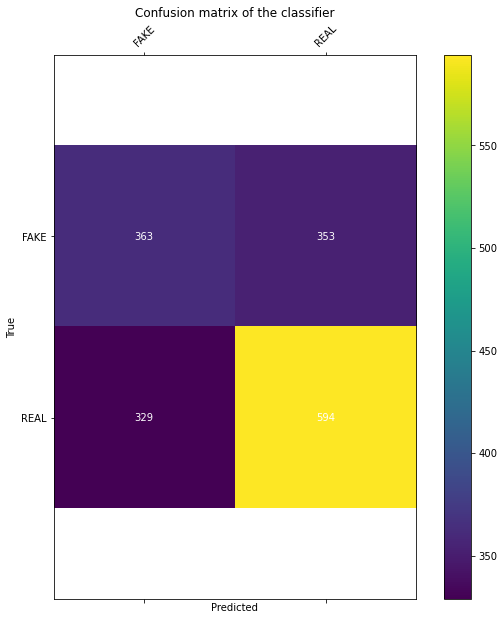



The classification report of the model:  
               precision    recall  f1-score   support

        FAKE       0.52      0.51      0.52       716
        REAL       0.63      0.64      0.64       923

    accuracy                           0.58      1639
   macro avg       0.58      0.58      0.58      1639
weighted avg       0.58      0.58      0.58      1639



In [22]:
# Use train_test_split method to split train_data and implement the classifier and receive the error analysis

# Import train_test_split method from sklearn and classification_report from sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_data_X = [t[0] for t in train_data] # Extract feature from train_data
train_data_y = [t[1] for t in train_data] # Extract true labels from train_data

# Split the train_data into sub-train and sub-test dataset with random seed = 123 (test size = 20%)
X_train, X_test, y_train, y_test = train_test_split(train_data_X, train_data_y, test_size = 0.2, random_state = 123)

#train the data with sub-train data and predict on sub-test set, get the confusion matrix and classification report for error analysis
data = []
for a, b in zip(X_train, y_train):
    data.append((a, b))
classifier = train_classifier(data) # Train
preds = predict_labels(X_test, classifier) # Predict
confusion_matrix_heatmap(y_test, preds, labels = ['FAKE', 'REAL']) # Plot heatmap with order FAKE-REAL
print('\n')

# Print out classification report
print('The classification report of the model:  \n',classification_report(y_test, preds))

**From the heatmap above and the classification report, there are some points that can be easily seen:**
- *The model built through out question 1 - question 4 seems to classify REAL labels better than FAKE ones*
- *The ratio of false positive and false negative case looks quite equal/balance*

## Print out/Print to file error type cases/text
## Explore and Analyze the error to see what may be the cause for misclassification

In [16]:
# Get false negative and false positive cases for FAKE labels to have initial analysis
test_feature = np.array(X_test)
test_truelabel = np.array(y_test)
test_predlabel = np.array(preds)
fn = test_feature[(test_truelabel == 'FAKE') & (test_predlabel == 'REAL')]
fp = test_feature[(test_truelabel == 'REAL') & (test_predlabel == 'FAKE')]

In [207]:
# Print out false positive cases (features extracted) - 20 examples
fp[:19]

array([{'Under': 1, 'the': 1, 'Obama': 1, 'administration,': 1, 'we': 2.0, 'are': 1, 'drilling': 1, 'and': 1, 'producing': 1, 'more': 1, 'domestic': 1, 'energy': 1, 'supplies': 1, 'than': 1, 'ever': 1, 'had': 1, 'before.': 1},
       {'Says': 1, 'Lake': 1, 'Erie': 1, 'contains': 1, 'more': 1, 'native': 1, 'fish': 1, 'than': 1, 'all': 1, 'the': 1, 'other': 1, 'Great': 1, 'Lakes': 1, 'combined.': 1},
       {'Social': 2.0, 'Security': 2.0, 'didnt': 1, 'cause': 1, 'the': 2.0, 'debt': 2.0, 'crisis.': 2.0, 'had': 1, 'nothing': 1, 'to': 1, 'do': 1, 'with': 1},
       {'Says': 1, 'New': 1, 'Jerseys': 1, '$1': 1, 'billion': 1, 'horse': 2.0, 'racing': 1, 'industry': 1, 'employs': 1, '13,000': 1, 'individuals': 1, 'and': 1, 'ensures': 1, 'the': 1, 'preservation': 1, 'of': 2.0, '176,000': 1, 'acres': 1, 'farmland.': 1},
       {'Hillary': 1, 'Clinton': 1, 'wants': 1, 'to': 1, '"wave': 1, 'the': 1, 'white': 1, 'flag': 1, 'of': 1, 'surrender': 1, 'and': 1, 'set': 1, 'a': 1, 'date': 1, 'for': 1, 'wi

In [208]:
# Print out false negative cases (features extracted) - 20 examples
fn[:19]

array([{'Right': 1, 'now': 1, 'the': 3.0, 'Tea': 1, 'Party': 1, 'polls': 1, 'higher': 1, 'than': 1, 'Republicans': 1, 'and': 1, 'Democrats.': 1},
       {'Under': 1, 'Obamacare,': 1, 'Virginia': 1, 'taxpayers': 1, 'would': 1, 'have': 1, 'been': 1, 'forced': 1, 'to': 1, 'pay': 1, 'for': 1, 'abortions': 1, 'if': 1, 'the': 1, 'General': 1, 'Assembly': 1, 'had': 1, 'not': 1, 'recently': 1, 'intervened.': 1},
       {'The': 1, 'number': 1, 'of': 1, 'uninsured': 1, 'people': 1, 'in': 2.0, 'Massachusetts': 1, 'is': 1, 'about': 1, 'the': 2.0, 'same': 1, 'as': 1, 'it': 1, 'was': 1, 'when': 1, 'mandates': 1, 'were': 1, 'passed': 1, '2006.': 1},
       {'Says': 1, 'Demond': 1, 'Means,': 1, 'turnaround': 1, 'district': 2.0, 'superintendent': 1, 'for': 1, 'Milwaukee': 1, 'Public': 1, 'Schools,': 1, 'said': 1, 'the': 1, 'needs': 1, 'to': 1, 'be': 1, 'gutted.': 1},
       {'We': 1, 'are': 1, 'already': 1, 'almost': 1, 'halfway': 1, 'to': 1, 'our': 1, '2010': 1, 'goal': 1, 'of': 1, 'creating': 1, '700

In [209]:
# Furthermore, print out true positive cases (features extracted) to have a comparison - 20 examples
tp = test_feature[(test_truelabel == 'FAKE') & (test_predlabel == 'FAKE')]
tp[:19]

array([{'Says': 1, 'the': 3.0, 'Club': 1, 'for': 1, 'Growth': 1, 'tries': 1, 'to': 1, 'defeat': 1, 'Republicans,': 1, 'and': 1, 'that': 1, 'its': 1, 'president': 1, 'called': 1, 'Nancy': 1, 'Pelosi': 1, 'person': 1, 'I': 1, 'respect': 1, 'most': 1, 'in': 1, 'Washington.': 1},
       {'The': 1, 'American': 1, 'people': 1, 'dont': 1, 'want': 1, 'us': 1, 'to': 1, 'raise': 1, 'taxes.': 1},
       {'With': 1, 'Obamacare,You': 1, 'have': 1, 'no': 1, 'options': 1, '..you': 1, 'cant': 1, 'get': 1, 'competitive': 1, 'bidding.': 1},
       {'Right': 1, 'now,': 1, 'Im': 1, 'polling': 1, 'at': 1, 'about': 1, '8': 1, 'percent': 1, 'against': 1, 'Barack': 1, 'Obama': 1, 'and': 1, 'Mitt': 1, 'Romney.': 1},
       {'Under': 1, "Obama's": 1, 'budget': 1, 'plan,': 1, 'families': 1, 'making': 1, 'over': 1, '$250,000': 1, 'are': 1, 'going': 1, 'to': 1, 'lose': 1, 'their': 2.0, 'mortgage': 1, 'deduction,': 1, 'charitable': 1, 'deductions.': 1},
       {'On': 1, 'whether': 1, 'he': 1, 'would': 1, 'run': 1, 

In [210]:
# Also, print out true negative cases (features extracted) to have a comparison - 20 examples
tn = test_feature[(test_truelabel == 'REAL') & (test_predlabel == 'REAL')]
tn[:19]

array([{'Rhode': 1, 'Island': 1, 'has': 1, 'a': 1, 'very': 1, 'generous': 1, 'unemployment': 1, 'compensation': 1, 'rate': 1, 'compared': 1, 'to': 1, 'most': 1, 'other': 1, 'states.': 1},
       {'Says': 1, 'Catherine': 1, 'Cortez': 1, 'Masto': 1, 'indicted': 1, '(Brian': 1, 'Krolicki),': 1, 'who': 1, 'was': 1, 'an': 1, 'innocent': 1, 'man,': 1, 'in': 1, 'order': 1, 'to': 1, 'save': 1, 'Harry': 1, 'Reids': 1, 'political': 1, 'career': 1},
       {'In': 1, 'the': 3.0, 'period': 1, 'from': 1, '2007': 1, 'to': 1, '2011,': 1, 'Office': 1, 'of': 1, 'Health': 1, 'Insurance': 1, 'Commissioner': 1, 'reported': 1, 'an': 1, '18': 1, 'percent': 1, 'decline': 1, 'in': 1, 'states': 1, 'total': 1, 'medical': 1, 'spending.': 1},
       {'Health': 1, 'insurance': 1, 'premiums': 1, '"have': 1, 'almost': 1, 'doubled': 1, '...': 1, 'since': 1, '2000."': 1},
       {'The': 1, 'average': 1, 'kid': 1, 'comes': 1, 'out': 1, 'of': 1, 'Virginia': 1, 'colleges': 1, 'with': 1, 'about': 1, '$25,000-plus': 1, 'in'

In [62]:
# Convert false positive cases into DataFrame which as 4 columns: Text - True label - Predicted label and Error Type (this is what we need to primarily focus on and analyze)
import pandas as pd # import pandas
fpositive = [] #create a list to store text concatenated from feature keys
for i in fp:
    sent = ' '.join(i)
    fpositive.append(sent)
false_positive = pd.DataFrame(fpositive, columns=['text']) # Convert into DataFrame
false_positive['true_label'] = 'REAL' # Add true_label column with value 'REAL'
false_positive['pred_label'] = 'FAKE' # Add pre_label column with value 'FAKE'
false_positive['error_type'] = 'false_positive' # Add error type column with value 'false postive'
false_positive.head(5)

,text,true_label,pred_label,error_type
0,"Under the Obama administration, we are drillin...",REAL,FAKE,false_positive
1,Says Lake Erie contains more native fish than ...,REAL,FAKE,false_positive
2,Social Security didnt cause the debt crisis. h...,REAL,FAKE,false_positive
3,Says New Jerseys $1 billion horse racing indus...,REAL,FAKE,false_positive
4,"Hillary Clinton wants to ""wave the white flag ...",REAL,FAKE,false_positive


In [197]:
# Similarly, do the same converting with false negative cases (this is what we need to primarily focus on and analyze)
fnegative = []
for i in fn:
    sent = ' '.join(i)
    fnegative.append(sent)
false_negative = pd.DataFrame(fnegative, columns=['text'])
false_negative['true_label'] = 'FAKE'
false_negative['pred_label'] = 'REAL'
false_negative['error_type'] = 'false_negative'
false_negative.head(5)

,text,true_label,pred_label,error_type
0,Right now the Tea Party polls higher than Repu...,FAKE,REAL,false_negative
1,"Under Obamacare, Virginia taxpayers would have...",FAKE,REAL,false_negative
2,The number of uninsured people in Massachusett...,FAKE,REAL,false_negative
3,"Says Demond Means, turnaround district superin...",FAKE,REAL,false_negative
4,We are already almost halfway to our 2010 goal...,FAKE,REAL,false_negative


In [64]:
# Additionally, do the same converting with true positive cases (simply for reference)
tpositive = []
for i in tp:
    sent = ' '.join(i)
    tpositive.append(sent)
true_positive = pd.DataFrame(tpositive, columns=['text'])
true_positive['true_label'] = 'FAKE'
true_positive['pred_label'] = 'FAKE'
true_positive['error_type'] = 'true_positive'
true_positive.head(5)

,text,true_label,pred_label,error_type
0,Says the Club for Growth tries to defeat Repub...,FAKE,FAKE,true_positive
1,The American people dont want us to raise taxes.,FAKE,FAKE,true_positive
2,"With Obamacare,You have no options ..you cant ...",FAKE,FAKE,true_positive
3,"Right now, Im polling at about 8 percent again...",FAKE,FAKE,true_positive
4,"Under Obama's budget plan, families making ove...",FAKE,FAKE,true_positive


In [70]:
# Additionally, do the same converting with true negative cases (simply for reference)
tnegative = []
for i in tn:
    sent = ' '.join(i)
    tnegative.append(sent)
true_negative = pd.DataFrame(tnegative, columns=['text'])
true_negative['true_label'] = 'REAL'
true_negative['pred_label'] = 'REAL'
true_negative['error_type'] = 'true_negative'
true_negative.head(5)

,text,true_label,pred_label,error_type
0,Rhode Island has a very generous unemployment ...,REAL,REAL,true_negative
1,Says Catherine Cortez Masto indicted (Brian Kr...,REAL,REAL,true_negative
2,"In the period from 2007 to 2011, Office of Hea...",REAL,REAL,true_negative
3,"Health insurance premiums ""have almost doubled...",REAL,REAL,true_negative
4,The average kid comes out of Virginia colleges...,REAL,REAL,true_negative


In [198]:
# Concatenate all the type
error_cases = pd.concat([false_positive, false_negative, true_positive, true_negative])
error_cases.shape

(1639, 4)

In [199]:
# The dataframe to be printed out would look like below
error_cases.head(5)

,text,true_label,pred_label,error_type
0,"Under the Obama administration, we are drillin...",REAL,FAKE,false_positive
1,Says Lake Erie contains more native fish than ...,REAL,FAKE,false_positive
2,Social Security didnt cause the debt crisis. h...,REAL,FAKE,false_positive
3,Says New Jerseys $1 billion horse racing indus...,REAL,FAKE,false_positive
4,"Hillary Clinton wants to ""wave the white flag ...",REAL,FAKE,false_positive


In [72]:
# Print the error type to file for further examination
error_cases.to_csv('error_case.csv')

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

False Positive wordcloud:


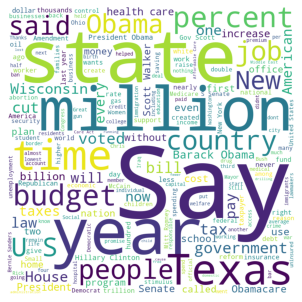

False Negative wordcloud:


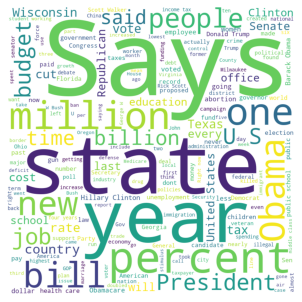

In [181]:
!pip install wordcloud
from wordcloud import WordCloud
# Word Cloud for false positive
wc_fp = []
for i in fp:
    for key in i:
        wc_fp.append(key)
all_fp = " ".join(wc_fp)
wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_fp)
print('False Positive wordcloud:')
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Word Cloud for false negative
wc_fn = []
for i in fn:
    for key in i:
        wc_fn.append(key)
all_fn = " ".join(wc_fn)
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_fn)
print('False Negative wordcloud:')
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

From observation of consolidated false positive and false negative examples, there are some points we may take into consideration to improve the model:
- There are a lot of too common words, such as a/an/the/we/will/etc., which presumably do not contribute much to model performance <br>
==> **Idea**: we can consider *removing these* to keep only meaningful features
- The text includes a combination of capital letters and lower ones, which may lead the model to some confusion <br>
==> **Idea**: we can consider *'normalisation'* method to convert all word into lowercase, which may reduce any unecessary biasness
- From word cloud plot, we can see the word 'say' and its variants (says/said) account for a large part in the text. These words indicate that the text could be understood by a statement, said/accompanied by somebody. However, since we use a unigram as features (there would be no history of the speaker and/or the topic presented by the speaker), it could be hard for the model to predict if the statement is REAL or FAKE <br>
==> **Idea**: we can think of *adding more features* so as to enrich the context/background of the statement, like the history of speaker's credibility or information about party affiliation
- The splitting (tokenization) method seems not to well separate the text from special characters, for instance, some are still attached to either comma or point <br>
==> **Idea**: the nltk package provides a method called *word_tokenize* which well splits the text into tokens in a clean way, we can try to use this

average and median text length by ground truth label: true_label
FAKE     99.587989
REAL    103.758397
Name: text_length, dtype: float64 true_label
FAKE    93.0
REAL    98.0
Name: text_length, dtype: float64


average and median text length by error type: error_type
false_negative     99.320113
false_positive    101.428571
true_negative     105.048822
true_positive      99.848485
Name: text_length, dtype: float64 error_type
false_negative     94.0
false_positive     96.0
true_negative     100.0
true_positive      93.0
Name: text_length, dtype: float64


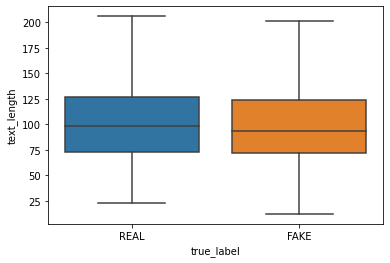

In [204]:
error_cases['text_length'] = error_cases.text.apply(len)
sns.boxplot(data = error_cases, x = 'true_label', y = 'text_length', showfliers=False)

avg_text_len = error_cases.groupby('true_label')['text_length'].mean()
med_text_len = error_cases.groupby('true_label')['text_length'].median()
print('average and median text length by ground truth label:', avg_text_len, med_text_len)

print('\n')

avg_len = error_cases.groupby('error_type')['text_length'].mean()
med_len = error_cases.groupby('error_type')['text_length'].median()
print('average and median text length by error type:', avg_len, med_len)

average and median non-text count by ground truth label: true_label
FAKE    19.208101
REAL    20.955580
Name: nontext_count, dtype: float64 true_label
FAKE    18.0
REAL    20.0
Name: nontext_count, dtype: float64


average and median non-text count by error type: error_type
false_negative    19.240793
false_positive    20.249240
true_negative     21.346801
true_positive     19.176309
Name: nontext_count, dtype: float64 error_type
false_negative    18.0
false_positive    19.0
true_negative     20.0
true_positive     18.0
Name: nontext_count, dtype: float64


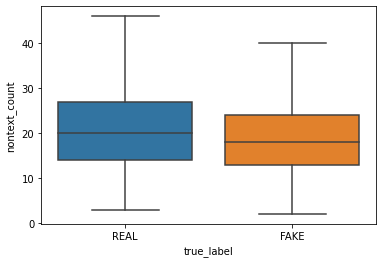

In [205]:
nontext = []
for x in error_cases.text:
    count = 0
    for y in x:
        if not str(y).lower().isalpha():
            count += 1
    nontext.append(count)
error_cases['nontext_count'] = nontext
sns.boxplot(data = error_cases, x = 'true_label', y = 'nontext_count', showfliers=False)

avg_nontext_count = error_cases.groupby('true_label')['nontext_count'].mean()
med_nontext_count = error_cases.groupby('true_label')['nontext_count'].median()
print('average and median non-text count by ground truth label:', avg_nontext_count, med_nontext_count)

print('\n')

avg_nontext = error_cases.groupby('error_type')['nontext_count'].mean()
med_nontext = error_cases.groupby('error_type')['nontext_count'].median()
print('average and median non-text count by error type:', avg_nontext, med_nontext)

<AxesSubplot:xlabel='true_label', ylabel='nontext_count'>

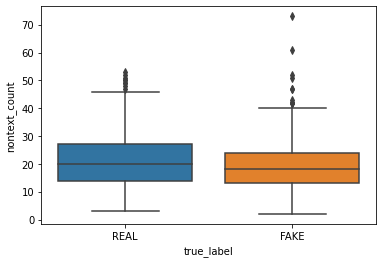

In [206]:
# non-text count boxplot by true labels with outliers
sns.boxplot(data = error_cases, x = 'true_label', y = 'nontext_count', showfliers=True)

Besides the above-mentioned ideas, there are other 2 aspects we can look into and try to add it as a feature to test whether they can improve the model either individually or in a combined way:
- text length: there is a visible difference of the length of text/sentence between REAL and FAKE news
- count of non-text words: REAL news seems to have a bit higher quantity of non-text count with less outliers